# Mutations across Passages

## Processing Cosmic and Gene Variants

Input all observed cosmic variants across all samples and output several visualizations and summary files including:

1. Venn diagrams of variant flow across passages (F0 -> F5 and Primary -> F0 -> F5)
2. Gene and cosmic variant tables describing when genes are mutated across passages

## Note that samples with multiple metastases are not analyzed in this script

See `metastatic_passages.ipynb` for more in depth analysis

In [1]:
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles

In [2]:
%matplotlib inline

In [3]:
# Load Processing Functions

def build_venn(df, sample_base, variant_type):
    """
    Create overlapping sets from cosmic or gene variants to build Venn Diagrams
    
    Arguments:
    df - a cosmic or gene dataframe storing specific variants across passages
    sample_base - the patient id the PDX models were derived from
    variant_type - which variant class to subset ('gene' or 'cosmic')
    
    Output:
    Matplotlib axes to build a venn diagram
    """
    
    if variant_type == 'gene':
        subset_variant = 'Gene.refGene'
    elif variant_type == 'cosmic':
        subset_variant = 'cosmic70'
    
    # Build Venn Diagram for cosmic variants
    f0 = '{}-F0'.format(sample_base)
    f5 = '{}-F5'.format(sample_base)
    prim = '{}-primary'.format(sample_base)
    
    # Get sets of variants matching specific passages
    set_f0 = set(df.query('sample_name == @f0')[subset_variant])
    set_f5 = set(df.query('sample_name == @f5')[subset_variant])
    set_prim = set(df.query('sample_name == @prim')[subset_variant])

    # Build venn diagram
    if len(set_prim) == 0:
        v = venn2(subsets=(set_f0, set_f5), set_labels = (f0, f5))
        v.get_patch_by_id('11').set_color('#fdff5b')
        v.get_patch_by_id('10').set_color('#b8ff87')
        v.get_patch_by_id('01').set_color('#82fffc')
        c = venn2_circles(subsets=(set_f0, set_f5), linestyle='dashed')
    else:
        v = venn3(subsets=(set_f0, set_f5, set_prim), set_labels = (f0, f5, prim))
        v.get_patch_by_id('110').set_color('#fdff5b')
        v.get_patch_by_id('100').set_color('#b8ff87')
        v.get_patch_by_id('010').set_color('#82fffc')
        v.get_patch_by_id('001').set_color('#ff82cf')
        v.get_patch_by_id('101').set_color('#ffb05b')
        v.get_patch_by_id('011').set_color('#992dff')
        v.get_patch_by_id('111').set_color('#6872ff')
        c = venn3_circles(subsets=(set_f0, set_f5, set_prim), linestyle='dashed')
    
    # Obtain axes and show plot
    plt.title('{} {}'.format(sample_base, variant_type))
    fig = plt.gcf()
    venn_fig = os.path.join('figures', 'venns',
                            'venn_{}_{}.pdf'.format(sample_base, variant_type))
    plt.tight_layout()
    plt.savefig(venn_fig)
    plt.show()
    return fig


def classify_passage(variant_sub_df, cosmic_passages):
    """
    Determine the pattern of the variants across passages. The pattern
    represents how the variants are observed across primary tumors, F0
    mice or F5 mice. If a variant exists in a sample that has only F0
    and F5 mice (no primary tumor), then the variant will get a `Both`
    assignment. If the variant exists in F0, F5, and Primary (in the
    two samples with Primary tumor data), then the variant will be
    assigned `All`. 
    
    Arguments:
    cosmic_sub_df - where a specific variant is observed across samples
    cosmic_passages - total number of passage types per sample base

    Output:
    The pattern of where the variant was observed
    """

    variant_sub_df = variant_sub_df.drop_duplicates(subset='sample_name')
    num_var = len(set(variant_sub_df['sample_name']))
    # Classify the passage type 
    if num_var == 0:
        return 0
    if num_var == 1:
        passage = variant_sub_df['sample_name'].tolist()[0].split('-')[1]
    if num_var == 2:
        if cosmic_passages.shape[0] == 2:
            passage = 'Both'
        else:
            passage = '_'.join(
                [x.split('-')[1]
                 for x in variant_sub_df['sample_name'].sort_values()])
    if num_var == 3:
        passage = 'All'
    
    return passage

## Load Files

In [4]:
cosmic_file = os.path.join('results', 'all_cosmic_variants.tsv')
cosmic_df = pd.read_table(cosmic_file)
cosmic_df = cosmic_df.assign(sample_base =
                           [x[0] for x in cosmic_df['sample_name'].str.split('-')])

In [5]:
use_cols = ['sample_name', 'sample_base', 'depth',
            'Gene.refGene', 'Func.refGene', 'GeneDetail.refGene',
            'ExonicFunc.refGene', 'AAChange.refGene', 'cosmic70']
cosmic_df = cosmic_df.loc[:, use_cols]
cosmic_df.head(5)

,sample_name,sample_base,depth,Gene.refGene,Func.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,cosmic70
0,019-F0,019,20,SAMD11,exonic,.,nonframeshift deletion,SAMD11:NM_152486:exon7:c.645_692del:p.G220Dfs*447,ID=COSM1344642;OCCURENCE=2(large_intestine)
1,019-F0,019,31,CNKSR1,exonic,.,frameshift deletion,CNKSR1:NM_001297647:exon9:c.866delC:p.P291Hfs*...,ID=COSM1341306;OCCURENCE=1(large_intestine)
2,019-F0,019,127,OR10Z1,exonic,.,nonsynonymous SNV,OR10Z1:NM_001004478:exon1:c.G655A:p.A219T,ID=COSM897769;OCCURENCE=1(endometrium)
3,019-F0,019,87,AIM2,exonic,.,frameshift deletion,AIM2:NM_001348247:exon5:c.712delA:p.T238HREVKR...,"ID=COSM1172051;OCCURENCE=6(large_intestine),2(..."
4,019-F0,019,83,LAMC2,exonic,.,nonsynonymous SNV,"LAMC2:NM_005562:exon4:c.C493T:p.R165C,LAMC2:NM...",ID=COSM1337002;OCCURENCE=1(large_intestine)


In [6]:
# Load Phenotype file
phenotype_file = 'pdx_phenotype.csv'
pheno_df = pd.read_csv(phenotype_file)
pheno_df = pheno_df.assign(sample_base =
                           [x[0] for x in pheno_df['sample_name'].str.split('-')])
pheno_df.head(5)

,sample,sample_name,pt,pool,read_id,wes_id,extract,location,passage,tumor,date,ln2,rna,pedigree,sample_base
0,KS1,001-F0,1,2,001-F0_S3_L001_R1_001,001-F0_S3_L001_001,FNA,NaN,F0,F0-R-2464,5.2.12,1.0,0.0,1.0,001
1,KS1,001-F0,1,2,001-F0_S3_L001_R2_001,001-F0_S3_L001_001,FNA,NaN,F0,F0-R-2464,5.2.12,1.0,0.0,1.0,001
2,KS1,001-F0,1,2,001-F0_S3_L002_R1_001,001-F0_S3_L002_001,FNA,NaN,F0,F0-R-2464,5.2.12,1.0,0.0,1.0,001
3,KS1,001-F0,1,2,001-F0_S3_L002_R2_001,001-F0_S3_L002_001,FNA,NaN,F0,F0-R-2464,5.2.12,1.0,0.0,1.0,001
4,KS1,001-F0,1,2,001-F0_S3_L003_R1_001,001-F0_S3_L003_001,FNA,NaN,F0,F0-R-2464,5.2.12,1.0,0.0,1.0,001


In [7]:
# The sample_base represents a single patient the original tumor was derived from
pheno_df['sample_base'].value_counts()

008    64
009    32
005    24
004    24
001    16
030    16
006    16
029    16
040    16
032    16
Name: sample_base, dtype: int64

## Process Cosmic ID and Gene ID files

In [8]:
all_unique_cosmic_df = cosmic_df.drop_duplicates(subset='cosmic70')
all_unique_cosmic_df.index = all_unique_cosmic_df['cosmic70']

unique_cosmic_df = all_unique_cosmic_df.drop(
    ['cosmic70', 'sample_name', 'sample_base', 'depth'], axis=1)

# Create variables where gene-passage relationship is stored
unique_cosmic_df = unique_cosmic_df.assign(F0 = 0)
unique_cosmic_df = unique_cosmic_df.assign(Both = 0)
unique_cosmic_df = unique_cosmic_df.assign(F5 = 0)
unique_cosmic_df = unique_cosmic_df.assign(primary = 0)
unique_cosmic_df = unique_cosmic_df.assign(F0_primary = 0)
unique_cosmic_df = unique_cosmic_df.assign(F5_primary = 0)
unique_cosmic_df = unique_cosmic_df.assign(F0_F5 = 0)
unique_cosmic_df = unique_cosmic_df.assign(All = 0)

In [9]:
all_unique_gene_df = cosmic_df.drop_duplicates(subset='Gene.refGene')
all_unique_gene_df.index = all_unique_gene_df['Gene.refGene']

unique_gene_df = all_unique_gene_df.drop(
    ['Gene.refGene', 'Func.refGene', 'GeneDetail.refGene',
     'ExonicFunc.refGene', 'AAChange.refGene', 'cosmic70',
     'sample_name', 'sample_base', 'depth'], axis=1)

# Create variables where gene-passage relationship is stored
unique_gene_df = unique_gene_df.assign(F0 = 0)
unique_gene_df = unique_gene_df.assign(Both = 0)
unique_gene_df = unique_gene_df.assign(F5 = 0)
unique_gene_df = unique_gene_df.assign(primary = 0)
unique_gene_df = unique_gene_df.assign(F0_primary = 0)
unique_gene_df = unique_gene_df.assign(F5_primary = 0)
unique_gene_df = unique_gene_df.assign(F0_F5 = 0)
unique_gene_df = unique_gene_df.assign(All = 0)

In [10]:
# Save depth of variants in dictionaries
cosmic_depth_dict = {cosmic_id: [] for cosmic_id in set(unique_cosmic_df.index)}
gene_depth_dict = {gene_id: [] for gene_id in set(unique_gene_df.index)}

## Process Data and Output Venn Diagrams and Summary Tables

In [11]:
# These 8 samples have PDX passages of F0 and F5 mice.
# Two (004 and 005) also have primary tumor data
sample_ids = ['004', '005', '001', '006', '029', '030', '032', '040']

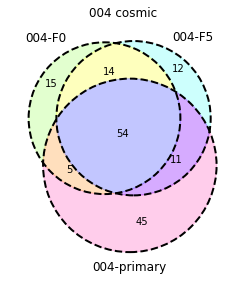

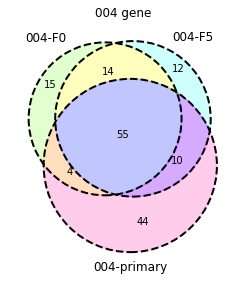

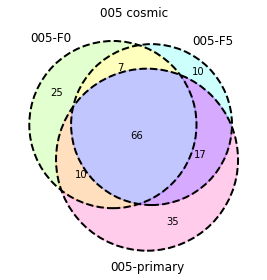

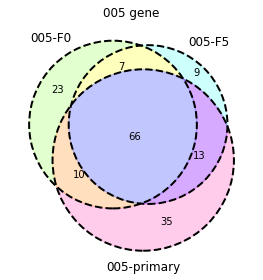

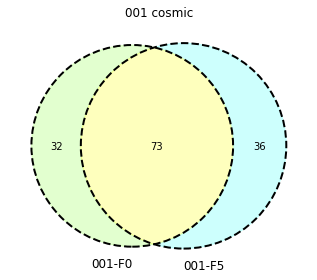

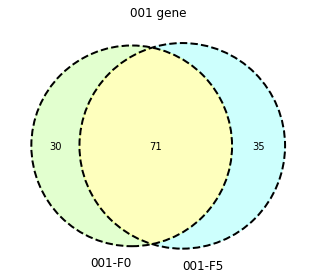

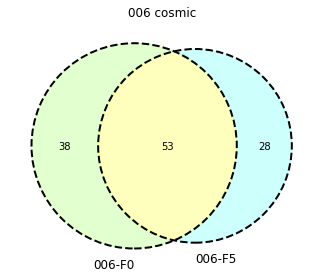

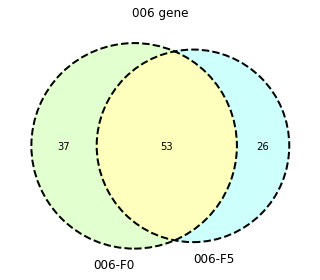

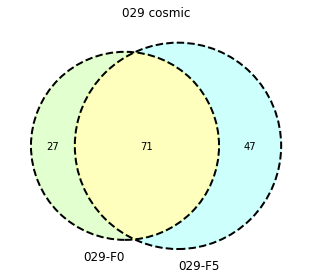

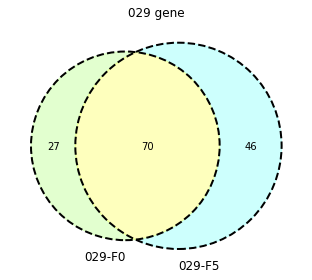

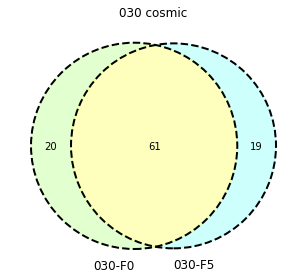

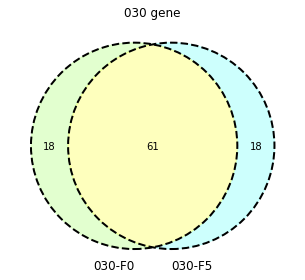

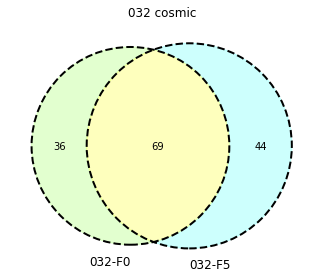

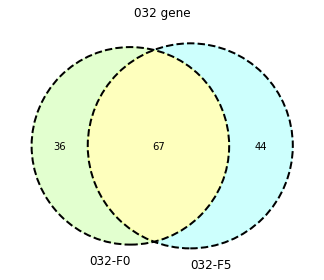

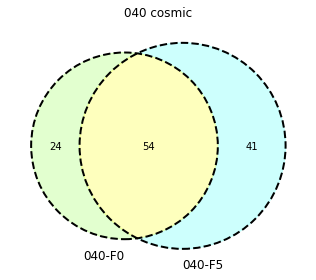

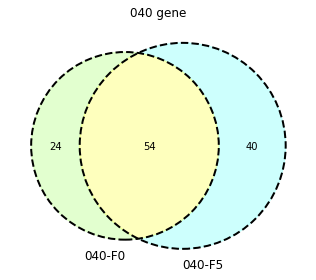

In [12]:
total_counts = {}
for sample_base in sample_ids:

    # Subset the full cosmic dataframe to the base sample name
    cosmic_sub_df = cosmic_df.query('sample_base == @sample_base')
    
    # Store the distribution of counts in separate dict
    cosmic_passage_counts = cosmic_sub_df['sample_name'].value_counts()
    total_counts[sample_base] = cosmic_passage_counts

    # Build Venn Diagram for cosmic variants
    cosmic_venn = build_venn(cosmic_sub_df, sample_base, 'cosmic')

    # Build cosmic dataframe passage counts
    sub_cosmic_ids = list(set(cosmic_sub_df['cosmic70']))
    for cosmic_id in sub_cosmic_ids:
        
        # Subset the cosmic df to the specific variant of interest
        cos_sub = cosmic_sub_df.query('cosmic70 == @cosmic_id')
        
        # Classify the passage pattern for the given cosmic id
        passage = classify_passage(cos_sub, cosmic_passage_counts)

        if passage == 0:
            continue

        # Store results of curation in cosmic dataframe
        avg_depth = cos_sub['depth'].mean()
        cosmic_depth_dict[cosmic_id].append(avg_depth)
        unique_cosmic_df.loc[cosmic_id, passage] += 1
        
    # Build gene dataframe passage counts
    gene_sub_df = cosmic_df.query('sample_base == @sample_base')

    # Build Venn Diagram for cosmic variants
    gene_venn = build_venn(gene_sub_df, sample_base, 'gene')

    # Build gene dataframe passage counts
    sub_gene_ids = list(set(gene_sub_df['Gene.refGene']))
    for gene_id in sub_gene_ids:
        
        # Subset the gene df to specific variant of interest
        gene_sub = gene_sub_df[gene_sub_df['Gene.refGene'] == gene_id]
        
        # Classify the passage pattern for the given cosmic id
        passage = classify_passage(gene_sub, cosmic_passage_counts)
        
        if passage == 0:
            continue

        # Store results in the gene data
        avg_depth = gene_sub['depth'].mean()
        gene_depth_dict[gene_id].append(avg_depth)
        unique_gene_df.loc[gene_id, passage] += 1

In [13]:
# Add average depth calculations to output tables
cosmic_depth_avg = {x: np.mean(y) for x, y in cosmic_depth_dict.items()}
gene_depth_avg = {x: np.mean(y) for x, y in gene_depth_dict.items()}

cosmic_depth_df = pd.DataFrame.from_dict(cosmic_depth_avg, orient='index')
cosmic_depth_df.columns = ['avg_read_depth']

gene_depth_df = pd.DataFrame.from_dict(gene_depth_avg, orient='index')
gene_depth_df.columns = ['avg_read_depth']

unique_cosmic_df = (
    unique_cosmic_df.merge(cosmic_depth_df, right_index=True, left_index=True)
    .sort_values(by='Both', ascending=False)
)
unique_gene_df = (
    unique_gene_df.merge(gene_depth_df, right_index=True, left_index=True)
    .sort_values(by='Both', ascending=False)
)

/home/gway/anaconda3/envs/pdx-exomeseq-analysis/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/gway/anaconda3/envs/pdx-exomeseq-analysis/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
# Save summary tables
cosmic_passage_file = os.path.join('results', 'passages_cosmic_flow.tsv')
gene_passage_file = os.path.join('results', 'passages_gene_flow.tsv')

unique_cosmic_df.to_csv(cosmic_passage_file, sep='\t')
unique_gene_df.to_csv(gene_passage_file, sep='\t')